In [2]:
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.core import ansatz, state
import qiskit

In [3]:
#define a custom ansatz
def custom_ansatz(num_qubits: int) -> qiskit.QuantumCircuit:
    qc = qiskit.QuantumCircuit(num_qubits)
    thetas = qiskit.circuit.ParameterVector(
        'theta', 2 * num_qubits)
    j = 0
    for i in range(num_qubits):
        qc.rx(thetas[j], i)
        qc.rz(thetas[j + 1], i)
        j += 2
    return qc    

In [4]:
#run the compiler  
num_qubits = 2
compiler = QuantumStatePreparation(
    u = custom_ansatz(num_qubits),
    target_state = state.w(num_qubits).inverse()
)

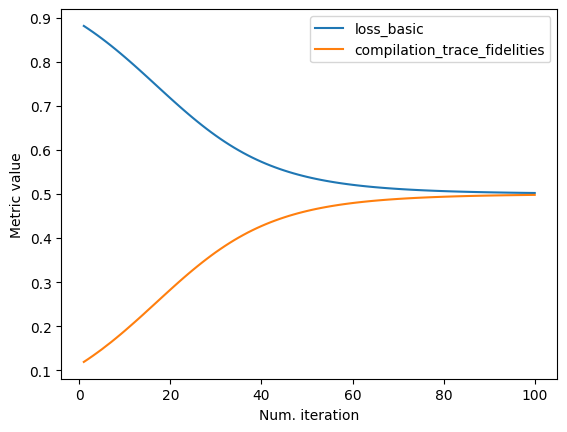

In [5]:
compiler.fit(
    num_steps = 100, 
    optimizer = 'sgd', 
    metrics_func = [
        'loss_basic', 
        'compilation_trace_fidelities'
    ]
)
#plot figure
compiler.plot()

In [6]:
import numpy as np
from qoop.compilation.qsp import QuantumStatePreparation

In [7]:
# Define the target state 
target_state = {
    "000": 1 / np.sqrt(2),
    "001": 1j / np.sqrt(6),
    "010": -1j / np.sqrt(3),
    "011": (1 + 1j) / (2 * np.sqrt(2)),
}

/home/cid/qoop/core/state.py:273: UserWarning: The input state is not normalized, we will normalize it for you
  warnings.warn("The input state is not normalized, we will normalize it for you")


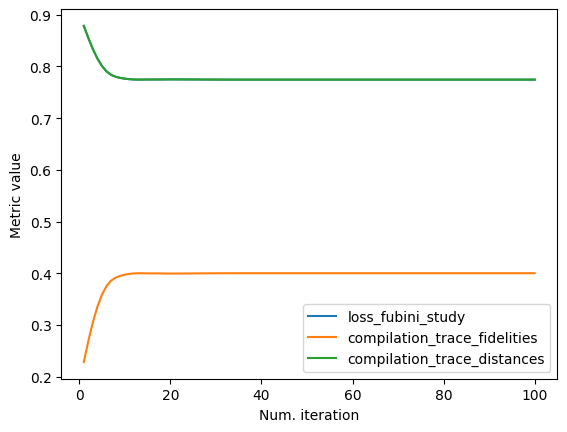

In [8]:
# Run the compiler
compiler = QuantumStatePreparation.prepare(target_state)

# Call and draw circuit U
compiler.u.draw('mpl')

# Plot figure of metric
compiler.plot()

In [8]:
import numpy as np
# Vector form
U = np.array(np.random.uniform(size=2**2))
# Matrix form
theta = np.pi/2
U = np.array([[1, 0, 0, 0], 
              [0, np.cos(theta), 0, np.sin(theta)], 
              [0, 0, 1, 0],
              [0, np.sin(theta), 0, -np.cos(theta)]]
)

In [9]:
compiler = QuantumStatePreparation.prepare(U)

In [2]:
import sys
sys.path.insert(0, '..')
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.core import ansatz, state
from qoop.backend import constant, utilities
import matplotlib.pyplot as plt
import numpy as np, qiskit
%load_ext autoreload
%autoreload 2

Mean loss [0.4999999999999998, 0.5, 0.5000000000000002, 0.5000000000000002, 0.5, 0.4999999999999998, 0.4999999999999999, 0.49999999999999967, 0.49999999999999956, 0.4999999999999998, 0.49999999999999956, 0.49999999999999967, 0.5, 0.4999999999999998, 0.4999999999999999, 0.49997195063714983, 0.5000000000000002, 0.5000000000000003, 0.4999999999999998, 0.5000000000000004, 0.49999999999999933, 0.49999999999999956, 0.5, 0.49999999999999967, 0.5000000000000001, 0.49999999999999967, 0.5000000000000001, 0.5000000000000003, 0.4999999999999999, 0.5000000000000004, 0.4999999999999998, 0.4999999999999998, 0.4999999999999998, 0.5, 0.4999999999999999, 0.4999999999999989, 0.5000000000000002, 0.5, 0.5000000000000012, 0.49999999999999967, 0.4999999999999992]


/home/cid/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/cid/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


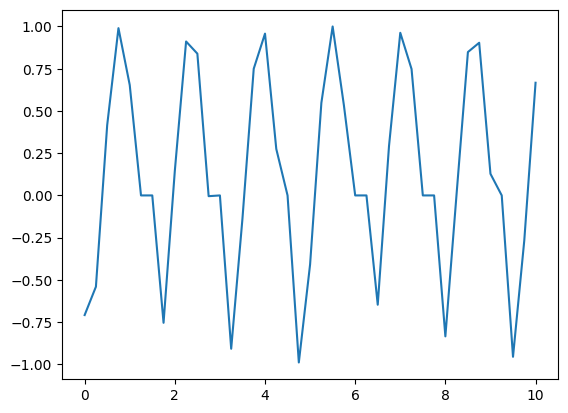

In [5]:
from scipy.linalg import expm
from qiskit.quantum_info import Pauli, Statevector
from qoop.compilation.qsp import QuantumStatePreparation

# Define Pauli matrices
XX = Pauli("XX").to_matrix()
YY = Pauli("YY").to_matrix()
ZZ = Pauli("ZZ").to_matrix()
ZI = Pauli("ZI").to_matrix()
IZ = Pauli("IZ").to_matrix()
# Set coefficients
J = 1.0
D = 0.0
h = 0.0
# Define H
H = J * (XX + YY) + D * ZZ + h * (ZI - IZ)
# define V(t), calculate U and local magnetization
p0s = []
time = np.linspace(0, 10, 41)
magnetization = []

def qsearch_ansatz(num_qubits: int, num_layers):
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    from qiskit.circuit import ParameterVector
    thetas = ParameterVector(
        'theta', 2 * num_layers)
    j = 0
    for _ in range(0, num_layers):
        qc.rx(np.pi / 2, 0)
        qc.rx(np.pi / 2, 1)
        qc.cx(0, 1)
        qc.rx(thetas[j], 0)
        qc.rx(thetas[j + 1], 1)
        qc.cx(0, 1)
        qc.rx(np.pi / 2, 0)
        qc.rx(np.pi / 2, 1)
        j += 2
    return qc
for t in time:
    V = expm(-1j * t * H)
    qc = qiskit.QuantumCircuit(2)
    qc.h(1)
    qc.unitary(V, list(range(0, 2)), label='InputUnita')
    
    compiler = QuantumStatePreparation(u=qsearch_ansatz(2, 2), target_state=qc.inverse()).fit(num_steps = 200, metrics_func=['loss_basic'])
    p0s.append(1-compiler.compiler.metrics['loss_basic'][-1])
    statevector = Statevector.from_instruction(
        compiler.u.assign_parameters(compiler.thetas)
    )
    # print(V)
    # print(V)
    # print(compiler.fidelity)
    # print(compiler.thetas)
    #print('---')
    psi_t = np.array(statevector.data).reshape(-1, 1)
    psi_t_dag = np.conj(psi_t.T)
    mag = (psi_t_dag @ ZI @ psi_t)[0][0] - (psi_t_dag @ IZ @ psi_t)[0][0]
    magnetization.append(0.5 * mag)

plt.plot(time, magnetization)
print('Mean loss',p0s)

In [6]:
print(compiler.fidelity)

0.4999998522188996304


In [22]:
from qiskit.quantum_info import SparsePauliOp
import sys, qiskit
import numpy as np
from scipy.linalg import expm
#from qiskit.extensions import UnitaryGate

def ising(N,J,h):
    """create Hamiltonian for Ising model
        H = J * sum_{i = 0}^{N-1) Z_i*Z_{i+1} + h*sum_{i=0}^{N-1}X_i
    """

    pauli_op_list = []  
    for j in range(N):
        s = ('I' * (N - j - 1)) + 'X' + ('I' * j)
        pauli_op_list.append((s, h))

    for j in range(N-1):
        s = ('I' * (N - j - 2)) + 'ZZ' + ('I' * j)
        pauli_op_list.append((s, J))
        
    h_op = SparsePauliOp.from_list(pauli_op_list)

    return h_op

def XYZ_bare(N,J,u,h):
    """create Hamiltonian for Ising model
        H = J * sum_{i = 0}^{N-1) Z_i*Z_{i+1} + h*sum_{i=0}^{N-1}X_i
    """
    

    pauli_op_list = []  
    for j in range(N):
        s = ('I' * (N - j - 1)) + 'X' + ('I' * j)
        pauli_op_list.append((s, h[j]))
    
    for j in range(N-1):
        s = ('I' * (N - j - 2)) + 'ZZ' + ('I' * j)
        pauli_op_list.append((s, u))
    
    for j in range(N-1):
        s = ('I' * (N - j - 2)) + 'XX' + ('I' * j)
        pauli_op_list.append((s, -J))

    for j in range(N-1):
        s = ('I' * (N - j - 2)) + 'YY' + ('I' * j)
        pauli_op_list.append((s, -J))
        
    h_op = SparsePauliOp.from_list(pauli_op_list)

    return h_op

def XYZ_model(N,J,u,h,T,t):
    """create Hamiltonian for Ising model
        H = J * sum_{i = 0}^{N-1) Z_i*Z_{i+1} + h*sum_{i=0}^{N-1}X_i
    """
    

    pauli_op_list = []  
    for j in range(N):
        s = ('I' * (N - j - 1)) + 'X' + ('I' * j)
        pauli_op_list.append((s, h[j]))
    
    for j in range(N-1):
        s = ('I' * (N - j - 2)) + 'ZZ' + ('I' * j)
        pauli_op_list.append((s, u))
    
    for j in range(N-1):
        s = ('I' * (N - j - 2)) + 'XX' + ('I' * j)
        pauli_op_list.append((s, -J*(1-t/T)/2.0))

    for j in range(N-1):
        s = ('I' * (N - j - 2)) + 'YY' + ('I' * j)
        pauli_op_list.append((s, -J*(1+t/T)/2.0))
        
    h_op = SparsePauliOp.from_list(pauli_op_list)

    return h_op

def pauli_oper(N, oper = None):
    
    pauli_op_list = []  
    s = ('I' * (N - 1)) + oper
    pauli_op_list.append((s, 1.0))
        
    h_op = SparsePauliOp.from_list(pauli_op_list)
    return h_op  

def pauli_ij(N, oper, pos):
    pauli_op_list = []
    s = 'I' * N

    for k in range(len(oper)):

        if oper[k] == s[N - pos[k]]:
            s = s[:N - pos[k]] + 'I' + s[N - pos[k] + 1:]
        else:
            s = s[:N - pos[k]] + oper[k] + s[N - pos[k]+ 1:]

    pauli_op_list.append((s, 1.0))

    h_op = SparsePauliOp.from_list(pauli_op_list)
    return h_op 

def pauli_collect(N, oper = None):
    
    pauli_op_list = []  
    for j in range(N):
        s = ('I' * (N - j - 1)) + oper + ('I' * j)
        print(s)
        pauli_op_list.append((s, 1.0))
        
    h_op = SparsePauliOp.from_list(pauli_op_list)
    return h_op  

def time_dependent_qc(num_qubits: int,h_opt, t):
    """create U circuit from h_opt and time t
    
    Args:
        - qc (QuantumCircuit): Init circuit
        - h_opt: Hamiltonian
        - t (float): time
        
    Returns:
        - QuantumCircuit: the added circuit
    """
    #Create circuit
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    for qubit in range(num_qubits//2, num_qubits):
        qc.x(qubit)
    
    # Ensure h_opt is Hermitian
    if not np.allclose(h_opt(t).to_matrix(), np.conj(h_opt(t).to_matrix()).T):
        raise ValueError("The Hamiltonian is not Hermitian.")

    time_points = np.linspace(0, t, 100)
    # Calculate the integral of H(t) using numerical approximation (e.g., trapezoidal rule)
    integral = np.zeros_like(h_opt, dtype=complex)  # Initialize integral as a matrix
    
    for i in range(len(time_points) - 1):
        dt = time_points[i + 1] - time_points[i]
        integral += (h_opt(time_points[i]) + h_opt(time_points[i + 1])) / 2 * dt

    # Compute the matrix exponential
    U = expm(-1j * integral)

    # Check if U is unitary
    if not np.allclose(U @ U.conj().T, np.eye(U.shape[0])):
        raise ValueError("The resulting matrix U is not unitary.")

    #return U matrix
    """
    # Create a UnitaryGate from the unitary_matrix
    unitary_gate = UnitaryGate(U)

    # Append the unitary_gate to the quantum circuit
    qc.append(unitary_gate, range(qc.num_qubits))
    """
    return U

def time_dependent_integral(h_opt, t):
    """create U circuit from h_opt and time t
    
    Args:
        - qc (QuantumCircuit): Init circuit
        - h_opt: Hamiltonian
        - t (float): time
        
    Returns:
        - QuantumCircuit: the added circuit
    """
    # Ensure h_opt is Hermitian
    if not np.allclose(h_opt(t).to_matrix(), np.conj(h_opt(t).to_matrix()).T):
        raise ValueError("The Hamiltonian is not Hermitian.")

    time_points = np.linspace(0, t, 100)
    # Calculate the integral of H(t) using numerical approximation (e.g., trapezoidal rule)
    integral = np.zeros_like(h_opt, dtype=complex)  # Initialize integral as a matrix
    
    for i in range(len(time_points) - 1):
        dt = time_points[i + 1] - time_points[i]
        integral += (h_opt(time_points[i]) + h_opt(time_points[i + 1])) / 2 * dt

    return integral

In [2]:
import sys, qiskit
sys.path.insert(0, '../../..')
import matplotlib.pyplot as plt
import numpy as np
import qoop
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.core import ansatz, state, random_circuit
from qoop.backend import constant, utilities
from qoop.evolution import crossover, mutate, selection, threshold
from qoop.evolution.environment import EEnvironment, EEnvironmentMetadata
import pickle
import model
import os

# def system coefs
def coefs(mod):
    #return coefs
    N=2
    J=1
    T=10
    #test mod
    if mod == 'mod1':  
        u=0
        h=[0,0]
    elif mod == 'mod2':
        u=-1
        h=[0.25,0.25]
    elif mod == 'mod3':
        u=1
        h=[0.25,0.25]
    elif mod == 'mod4':
        u=0.25
        h=[0.25,0.25]  
    elif mod == 'mod5':
        u=-0.25
        h=[0.25,0.25]  
    elif mod == 'mod6':
        u=-0.25
        h=[0,0]    
    elif mod == 'mod7':
        u=0.0
        h=[0.25,0.25] 
    elif mod == 'mod8': #same as 5
        u=-0.25
        h=[-0.25,-0.25]         
    return N, J, u, h, T     

mod = 'mod5'     
def h_time(t):
    N, J, u, h, T = coefs(mod)
    return model.XYZ_model(N,J,u,h,T,t)
    
def compilation_fitness(qc: qiskit.QuantumCircuit):
    p0s = []
    N, J, u, h, T = coefs(mod) 
    times = np.linspace(0,10,15)
    for time in times:
        qsp = QuantumStatePreparation(
            u=qc,
            target_state=model.time_dependent_qc(N,h_time,time).inverse()
            ).fit(num_steps=300, metrics_func=['loss_basic'])
        p0s.append(1-qsp.compiler.metrics['loss_basic'][-1])
        time_folder = os.path.join(f"times_{mod}/times= {time}")
        os.makedirs(time_folder, exist_ok=True)
        qsp.save(f"times_{mod}/times= {time}")
        
    return np.mean(p0s)

def super_evol(_depth, _num_circuit, _num_generation):
    env_metadata = EEnvironmentMetadata(
        num_qubits = num_qubits,
        depth = _depth,
        num_circuit = _num_circuit,
        num_generation = _num_generation,
        prob_mutate=3/(_depth * _num_circuit)
    )
    env = EEnvironment(
        metadata = env_metadata,
        fitness_func= compilation_fitness,
        selection_func=selection.elitist_selection,
        crossover_func=crossover.onepoint_crossover,
        mutate_func=mutate.layerflip_mutate,
        threshold_func=threshold.compilation_threshold
    )
    env.set_filename(f'n={mod},d={_depth},n_circuit={_num_circuit},n_gen={_num_generation}')
    env.evol()
    print('done')
    
# main
if __name__ == '__main__':
    num_qubits = 2
    super_evol(4,8,10)











Initialize list of circuit ...
Start evol progress ...
Running at generation 1


AttributeError: 'numpy.ndarray' object has no attribute 'inverse'

In [ ]:
#Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import sys, qiskit
from qiskit import QuantumCircuit
sys.path.insert(0, '../../..')
import numpy as np
import matplotlib.pyplot as plt
import qoop
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.evolution import crossover, mutate, selection, threshold
from qoop.evolution.environment import EEnvironment, EEnvironmentMetadata
from qoop.core import state
from qoop.backend import tools, utilities
import model
import csv
from scipy.linalg import expm
from qiskit.quantum_info import Pauli, SparsePauliOp

#mod
mod = 'mod1'

# def system coefs
def coefs(mod):
    #return coefs
    N=2
    J=1
    T=10
    #test mod
    if mod == 'mod1':  
        u=0
        h=[0,0]
    elif mod == 'mod2':
        u=-1
        h=[0.25,0.25]
    elif mod == 'mod3':
        u=1
        h=[0.25,0.25]
    elif mod == 'mod4':
        u=0.25
        h=[0.25,0.25]  
    elif mod == 'mod5':
        u=-0.25
        h=[0.25,0.25]  
    elif mod == 'mod6':
        u=-0.25
        h=[0,0]    
    elif mod == 'mod7':
        u=0.0
        h=[0.25,0.25] 
    elif mod == 'mod8':
        u=-0.25
        h=[-0.25,-0.25]         
    return N, J, u, h, T   
    
def h_time(t):
    N, J, u, h, T = coefs(mod)
    return model.XYZ_model(N,J,u,h,T,t)

def trotter_circuit(nqubits, labels, coeffs, t, M):

    # Convert one Trotter decomposition ,e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} to a quantum gate
    circuit = QuantumCircuit(nqubits)
    for qubit in range(nqubits//2, nqubits):
        circuit.x(qubit)

    # Time increment range
    delta = 0.5
        
    for i in range(len(labels)):
        # 'IX', 'IZ', 'IY' case
        if labels[i][0] == 'I':
            if labels[i][1] == 'Z':
                circuit.rz(2*delta*coeffs[i],1)
            elif labels[i][1] == 'X':
                circuit.rx(2*delta*coeffs[i],1)
            elif labels[i][1] == 'Y':
                circuit.ry(2*delta*coeffs[i],1)
    
        # 'XI', 'ZI', 'YI' case
        elif labels[i][1] == 'I':
            if labels[i][0] == 'Z':
                circuit.rz(2*delta*coeffs[i],0)
            elif labels[i][0] == 'X':
                circuit.rx(2*delta*coeffs[i],0)
            elif labels[i][0] == 'Y':
                circuit.ry(2*delta*coeffs[i],0)
    
        # # 'XX', 'ZZ', 'YY' case
        elif labels[i] in ['XX', 'YY', 'ZZ']:
            for j in range(nqubits):
                if labels[i][1] == 'Z':
                    #circuit.cx((j+1)%(nqubits),j)
                    circuit.rzz(2*delta*coeffs[i],(j+1)%nqubits, j) ## RZ(a)=exp(i*a/2*Z)
                    #circuit.cx((j+1)%(nqubits),j)
                elif labels[i][1] == 'X':
                    #circuit.cx((j+1)%(nqubits),j)
                    circuit.rxx(2*delta*coeffs[i],(j+1)%nqubits, j) ## RZ(a)=exp(i*a/2*Z)
                    #circuit.cx((j+1)%(nqubits),j)
                elif labels[i][1] == 'Y':
                    #circuit.cx((j+1)%(nqubits),j)
                    circuit.ryy(2*delta*coeffs[i],(j+1)%nqubits, j) ## RZ(a)=exp(i*a/2*Z)
                    #circuit.cx((j+1)%(nqubits),j)
    return circuit

def load_data_csv(fname):
    # Define the file name
    csv_file = f'{mod}_theta.csv'
    loaded_qc = utilities.load_circuit(fname)
    thetass = []
    
    # Read data from the CSV file
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Assuming theta values are stored as floats in the CSV file
            theta_values = [float(value) for value in row]
            thetass.append(theta_values)
    return loaded_qc, thetass

def plot_metrics(qcs,thetass):
    mag_ga = []
    mag_theo = [] 
    mag_trotter = []
    
    #get coefs
    N, J, u, h, T = coefs(mod)
    #ZI = SparsePauliOp(['ZI'], coeffs=[1+0.j])
    #IZ = SparsePauliOp(['IZ'], coeffs=[1+0.j])
    #op_Z = 0.5*(ZI - IZ)
    op_Z = model.pauli_oper(N,oper = 'Z') #use this back
    
    
    #for theory
    times_theo = np.linspace(0,10,100)  
    for i, time in enumerate(times_theo): 
        qc_theo = model.time_dependent_qc(N,h_time,time)
        exp_theo = tools.get_expectation(qc_theo,op_Z,None)   
        mag_theo.append(exp_theo) 
    
    #for ga       
    times_ga = np.linspace(0,10,100)  
    for i, time in enumerate(times_ga):     
        qc_ga = qcs
        qc_p = qc_ga.assign_parameters(thetass[i])
        #sv = np.array(qi.Statevector(qc_p))
        exp_ga = tools.get_expectation(qc_p,op_Z,None)   
        mag_ga.append(exp_ga)

    #for trotter
    times_trotter = np.linspace(0,10,100)
    for i,time in enumerate(times_trotter):
        labels = model.time_dependent_integral(h_time,t=time).paulis.to_labels()
        coeffs = model.time_dependent_integral(h_time,t=time).coeffs
        coeffs = np.real(coeffs)
        #print(coeffs)
        qc = trotter_circuit(N,labels,coeffs, time, M=100)
        #print(qc)
        exp_trotter = tools.get_expectation(qc,op_Z,None)   
        mag_trotter.append(exp_trotter)

    print(qc.depth())
    

    # Save mag_trotter to a CSV file
    with open(f'trotter_{mod}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Expectation Values"])  # Optional header
        for value in mag_trotter:
            writer.writerow([value])
    
    # Calculate the mean square error
    error_ga = np.real(np.array(mag_theo) - np.array(mag_ga))**2
    error_trotter = np.real(np.array(mag_theo) - np.array(mag_trotter))**2 
    plt.scatter(times_trotter, error_trotter, label="trotter", marker='v')
    plt.scatter(times_ga,error_ga,label='GA', marker='^')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('square error')
    plt.savefig(f'error_{mod}')
    plt.savefig(f'error_{mod}.eps', format='eps')
    plt.close()
    #mse = np.sum(error)/len(error)
    #print('mse= ', mse)

    plt.plot(times_theo,mag_theo,label='mag theo')  
    plt.scatter(times_trotter, mag_trotter, label="trotter", marker='v')
    plt.scatter(times_ga,mag_ga,label='mag ga',marker='^')

    plt.xlabel('time')
    plt.ylabel('magnetization')

    #AVQDS
    # Specify the file path
    csv_file = f"magnetization_data_{mod}.csv"

    # Load data using NumPy
    data = np.loadtxt(csv_file, delimiter=',', skiprows=1)  # Skip header row
    
    # Extract columns into separate lists (if needed)
    times_avqds = data[:, 0]  # First column (Time)
    mag_avqds = data[:, 1]   # Second column (Magnetization)
    plt.plot(times_avqds,mag_avqds,label='mag AVQDS')  
    plt.legend()
    plt.savefig(f'mag_{mod}.eps', format='eps')
    plt.savefig(f'mag_{mod}')
    
#main   
if __name__ == '__main__':
    fname = f'n={mod},d=4,n_circuit=8,n_gen=16/best_circuit'
    #loaded_qc, thetass = load_data(fname)  #run it if not csv yet
    loaded_qc, thetass = load_data_csv(fname) #run it if you have csv    
    plot_metrics(loaded_qc,thetass)


FileNotFoundError: [Errno 2] No such file or directory: 'n=mod1,d=4,n_circuit=8,n_gen=16/best_circuit.qpy'